### Formlabs Case Study
Author: Garret O'Connell

### The Data Set
Description: Data exported from Salesforce attached. This is a simplified version of what you would encounter as a Sales Operations Analyst at Formlabs. 

Variables: 
* Lead ID # ID code for prospective clients (type: categorical)
* Lead Owner # ID code for superordinate lead groupings (type: categorical)
* Team # ID code for subordinate lead groupings (type: categorical)
* Oldest Campaign # specific goal for lead (type: categorical)
* Converted # conversion (success) status for lead (type: binary)
* Time to lead conversion # duration of campaign (sorted descending) (type: ordinal)
* Industry # industry sector (type: categorical) 
* N of employee (type: numerical)
* Country (type: categorical) 

### Task
To place the data in context by identifying characteristics/trends with summary visualizations and reports.

### Approach
I chose to investigate which of the above variables contribute most to conversion rates to focus sales strategies . To identify these factors I fitted a Random Forests machine learning algorithm which performs well on categorical data such as these (for a basic overview of this algorithm see: https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd). From this model I identified variables that most strongly predicted conversion, and plotted the relationship between these variables and conversion rates to visualize precisely how this occurs. 

### Steps

Below are outline for each step taken in analysis:
1. Data importing/cleaning: data was imported to a data table for analysis, and variables were coded appropriately.


2. Data summary: basic summary statistics were calculated for all variables to characterise the data set.


3. Model fitting: data were structured appropriately for training the Random Forests Classifier.


4. Identify variables predicting conversion: rank variables in their ability to predict conversions.


5. Visualize patterns: Use graphs and figures to characterise the precise relationship between the identified variables above and conversion rates.

### 1. Data importing/cleaning

The missing values for "Time to Lead Conversion" and "No. of Employees" variables need to be recoded from "-" to NaN for analysis. Also commas need to be removed from "No. of Employees" numbers.

In [1]:
 # set paths
import os
import pandas as pd
import numpy as np
import seaborn as sns

# import data
path = os.getcwd()
df = pd.read_csv(os.path.join(path,'Case_for_Sales Operations Analyst.csv'), sep = ';')

In [2]:
df['Time to Lead ConversionSorted Descending'] = df['Time to Lead ConversionSorted Descending'].replace('-', np.NaN);
df['No. of Employees'] = df['No. of Employees'].replace('-', np.NaN);
df['No. of Employees'] = df['No. of Employees'].str.replace(',', '').astype(float);
df = df.drop(['Lead ID'],axis=1) # all IDs are unique so this variable is uninformative

### 2. Basic data summary

In [3]:
print('Number of total entries :',df.shape[0])
print('Number of unique Lead Owner :',df['Lead Owner'].unique().shape[0])
print('Number of unique Team :',df['Team'].unique().shape[0])
print('Number of unique Oldest Campaign :',df['Oldest Campaign'].unique().shape[0])
print('Number of unique Industry :',df['Industry'].unique().shape[0])
print('Number of unique Country :',df['Country'].unique().shape[0])
print('Percentage of conversions :',round((100*df['Converted'].sum()/df['Converted'].shape[0]),2))
print('Mean no. of employees :',round(df['No. of Employees'].mean()))

Number of total entries : 155
Number of unique Lead Owner : 10
Number of unique Team : 2
Number of unique Oldest Campaign : 6
Number of unique Industry : 5
Number of unique Country : 3
Percentage of conversions : 36.13
Mean no. of employees : 213


### Remark

These descriptive summaries of the data are useful for guiding analyses. For example, the data set is relatively small, and contains mainly categorical data with few levels. A Random Forests Classifier (or Logistic Regression) would be my first choices for a data set of this type.

### 3. Model fitting

In [4]:
# convert to categorical
for col in ['Lead Owner', 'Team', 'Oldest Campaign', 'Industry','Country']:
    df[col] = df[col].astype('category')

In [5]:
# drop columns 
df = df.drop(["Time to Lead ConversionSorted Descending"], axis = 1)
df.dropna(inplace=True)

# extract labels and features
df_labels = df['Converted']
df_features = df.drop(["Converted"], axis = 1)

# record labels for decode after classification
cat_columns = ['Lead Owner', 'Team', 'Oldest Campaign', 'Industry','Country']
label_list = []

for column in cat_columns:
    label_list.append(dict( enumerate(df_features[column].cat.categories) ))
    df_features[column] = df_features[column].astype('category').cat.codes

In [6]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# split train and test
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, random_state=0,test_size=0.2)

In [8]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score

# RF
clf_rf = RF(n_estimators=50)
clf_rf.fit(X_train, y_train)
y_predict_rf = clf_rf.predict(X_test)
score_rf = accuracy_score(y_test, y_predict_rf)

#### Model accuracy

In [9]:
print("Random Forest prediction accuracy:")
print("%.1f" % (100*score_rf),'%')

Random Forest prediction accuracy:
73.3 %


### Remark
The model performed reasonably well with 73.3% accuracy in predicting conversion (over twice that of chance levels of 36.1%). This suggests that information in certain variables was able to predict conversion. Which variables contain this information is indicated by the model's estimated "feature importance".

### 4. Identify variables predicting conversion:

In [10]:
feature_importances = pd.DataFrame(clf_rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print("Features ranked:")
print(feature_importances)

Features ranked:
                  importance
No. of Employees    0.302895
Lead Owner          0.208015
Industry            0.181755
Oldest Campaign     0.147930
Country             0.120743
Team                0.038662


### Remark
The two variables that explained a considerable amount of variability in conversion are "No. of Employees" and "Lead Owner", which I will investigate further with visualizations of their relationship with conversion rates.

### 5. Visualize patterns

### a) No. of Employees
No. of employees is a continuous variable and I will therefore visualise its relationship with conversion rates using a scatter plot. I visualized this relationship both in terms of percentage of conversions (rate of conversions relative to attempted conversions), and in terms of the absolute number of conversions. This addresses both rate of success of conversions and overall conversions as a function of no. of employees.

Note: From the average values of conversion rates at each group of employee numbers, there appears to be a non-linear relationship with conversion rates, so visualized this relationship by fitting a curved regression line that aims to fit as close as possible to the data points.

In [11]:
# groupby and sum converted
df_noemp = df.groupby(['No. of Employees','Converted'], sort=False, as_index=False)["Converted"].size().reset_index(name='Total')
df_noemp_pivot = df_noemp.pivot('No. of Employees','Converted').fillna(0).reset_index()
df_noemp_pivot["percentage conversions"] = df_noemp_pivot["Total"][1]/(df_noemp_pivot["Total"][0]+df_noemp_pivot["Total"][1])
df_noemp_pivot["total conversions"] = df_noemp_pivot["Total"][1]

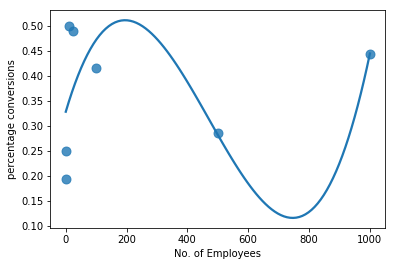

In [12]:
# plot curve
ax = sns.regplot(x="No. of Employees", y="percentage conversions", data=df_noemp_pivot, scatter_kws={"s": 80}, order=3, ci=None, truncate=True)

### Remark
For the line relating percentage of conversions to no. of employees, there does not appear to be any clear benefit of higher numbers of employees on percentage of conversions. In fact the data indicate ranges of relatively fewer employees (between 25 and 75) can yield higher conversion rates than those with more employees (> 1000). 

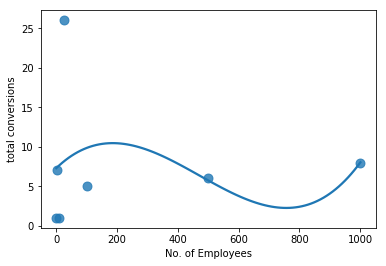

In [13]:
# plot curve
ax = sns.regplot(x="No. of Employees", y="total conversions", data=df_noemp_pivot, scatter_kws={"s": 80}, order=3, ci=None, truncate=True)

### Remark
Similar to above the line relating total conversions to no. of employees indicated no clear benefit of higher numbers of employees on the total number of conversions. Given these observations, I would make the strong recommendation to maximize resources by maintaining no. of employees in smaller ranges.

### b) Lead Owner
Lead owner is a categorical variable so I visualise its relationship with conversion rates using bar charts of the frequency of conversions for each leader. I use stacked bar charts to include information about not only overall frequency of conversions, but the relative number of conversions compared to attempted conversions (i.e. the ratio of successful to failed conversions). Hence, the recommendation from this analysis would be to maximize resources by 

In [ ]:
# plot conversion rates of individual Lead Owners
df_grp_leadowner = df.groupby(['Lead Owner','Converted'], sort=False, as_index=False)["Converted"].size().reset_index(name='Total')
df_pivoted = df_grp_leadowner.pivot('Lead Owner', 'Converted').fillna(0)
df_pivoted = df_pivoted.reset_index(0).reset_index(drop=True)
df_pivoted["Total",0] = df_pivoted.sum(1)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

# plot style
sns.set(style="whitegrid")
sns.set(font_scale=1.5)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 12))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x=df_pivoted["Total"][0], y=df_pivoted["Lead Owner"],
            label="Unconverted", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x=df_pivoted["Total",1], y=df_pivoted["Lead Owner"],
            label="Converted", color="b");

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, (df_pivoted.Total.max().max())+2), ylabel="",
       xlabel="Conversion rates in Teams")
sns.despine(left=True, bottom=True)

count = -1
converted = df_pivoted['Total'].as_matrix()
converted[:,0] = converted[:,0] - converted[:,1]

def annotateBars(row, ax=ax): 
       for counter,p in enumerate(ax.patches):  
             ax.annotate("%d" % converted.flatten(1)[counter], ((p.get_x() + p.get_width()-.5), p.get_y()+p.get_height()*.75),
                 ha='center', va='center', fontsize=15, color='white', rotation=90, xytext=(0, 20),
                 textcoords='offset points')  

plot = df_pivoted.apply(annotateBars, ax=ax, axis=0);

### Remark
Lead owner "ER" appears to be contributing disproportionately to lowering the rate of conversions. The underlying causes should be investigated to determine how to improve the conversion success of "ER". Sinice "ER" also has the highest number of conversion attempts, so efforts to improve their rates would yield substantial increases in overall conversions. Resources should therefore be allocated accordingly (e.g. distributing ER's workload, addressing areas of weakness leading to failed conversions). 